In [1]:
import re
import pandas as pd
import glob
import numpy as np
from Chemometrics.basic import read_mzxml,psave,pload
from mass_simple import filter0, rt_correction, match_df, result2excel,ppm,mzs
from mass_simple import avg_mass,rt_real,irons
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext line_profiler

In [2]:
allfiles = glob.glob("../data/*.mzxml")
f = allfiles[0]
f

'../data\\data010.mzXML'

In [3]:
df = read_mzxml(f)

In [4]:
def EIC(target_mz,df,error_theshold=20*ppm):
    # 提取EIC
    mzs = df.mz
    target_mask = abs(mzs-target_mz)<target_mz*error_theshold
    EIC = df[target_mask]
    return EIC

In [5]:
def Eretention_time(EIC):
    Ert = EIC.rt[EIC.intensity.idxmax()]
    return Ert

~~~py
mzrt = pd.concat(pd.read_excel('./保留时间线性校正数据.xlsx',sheetname=None).values())
mzrt.columns =['n','mz','rt']
psave(mzrt,'保留时间线性校正数据.p')
~~~

In [59]:
mzrt = pload('保留时间线性校正数据.p')

In [60]:
measured_rt = [Eretention_time(EIC(mz,df)) for mz in mzrt.mz]

In [61]:
mzrt['实测rt'] = measured_rt

In [79]:
from mass_simple import leastsq_correction_line

In [87]:
line = leastsq_correction_line(mzrt.实测rt,mzrt.rt)

In [88]:
mzrt['校正后'] = line(mzrt.实测rt)
mzrt = mzrt.sort_values('rt')

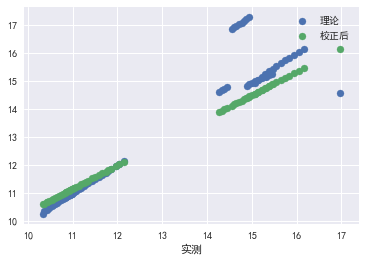

In [90]:
from sklearn.metrics import r2_score
plt.scatter(mzrt.实测rt,mzrt.rt,label='理论')
plt.scatter(mzrt.实测rt,mzrt.校正后,label='校正后')
plt.xlabel('实测')
plt.legend()

In [ ]:
def rt_line_correction(mass_measured, mzrt_theoretical=mzrt):
    """
    线性保留时间校正
    """

    rt_measured = [Eretention_time(EIC(mz,mass_measured)) for mz in mzrt_theoretical.mz]
    line = leastsq_correction_line(rt_measured,mzrt_theoretical.rt)
    rt_correct = line(mass_measured.rt)
    return rt_correct